Compiling model...
'compile' took 0.000970 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.48e-01, 5.62e-01]    [8.73e-01, 5.62e-01]    []  
1000      [5.05e-01, 4.61e-02]    [5.44e-01, 4.61e-02]    []  
2000      [6.56e-01, 6.68e-02]    [6.80e-01, 6.68e-02]    []  
3000      [5.57e-01, 7.64e-02]    [6.03e-01, 7.64e-02]    []  
4000      [5.00e-01, 5.79e-02]    [5.39e-01, 5.79e-02]    []  
5000      [4.05e-01, 6.86e-02]    [4.35e-01, 6.86e-02]    []  
6000      [3.93e-01, 7.77e-02]    [4.22e-01, 7.77e-02]    []  
7000      [3.21e-01, 5.21e-02]    [3.48e-01, 5.21e-02]    []  
8000      [1.85e-01, 3.70e-02]    [1.99e-01, 3.70e-02]    []  
9000      [3.65e-01, 4.53e-02]    [3.92e-01, 4.53e-02]    []  
10000     [2.71e-02, 1.84e-03]    [3.11e-02, 1.84e-03]    []  
11000     [3.23e-03, 3.49e-04]    [3.88e-03, 3.49e-04]    []  
12000     [6.58e-04, 1.28e-04]    [6.37e-04, 1.28e-04]    []  
13000     [5.11e-03, 8.68e-04]    [5.57e-03, 8

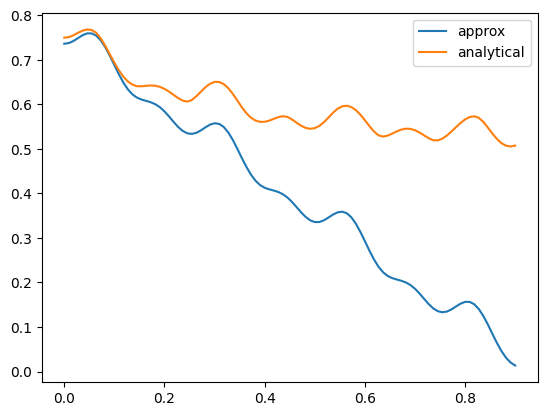

In [3]:
import deepxde as dde
from deepxde.backend import tf
import torch
import numpy as np
from scipy.integrate import solve_ivp

geom = dde.geometry.TimeDomain(0, 0.9)

def function_res(t, u):
    du_dt = dde.grad.jacobian(u, t)
    res = du_dt - (4*u[0] - 6*u[0]**2 + torch.sin(50*t) + u[0]*torch.cos(25*t) - 0.5)
    return res

def boundary(_, on_initial):
    return on_initial

ic = dde.icbc.IC(geom, lambda t: 0.75, boundary)


def sol(t):

    derivatives_fnc = lambda t,u: 4*u[0] - 6*u[0]**2 + np.sin(50*t) + u[0]*np.cos(25*t) - 0.5
    analytical_solution = solve_ivp(derivatives_fnc, [0,0.9], [0.75], dense_output=True)
    return analytical_solution.sol(t).T

data = dde.data.PDE(geom, function_res, [ic], 100, 1, num_test=30)

layer_size = [1] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.01)

losshistory, train_state = model.train(iterations=20000)

#dde.saveplot(losshistory, train_state, issave=True, isplot=True)

import matplotlib.pyplot as plt

t = np.linspace(0,0.9,100)
u_pred = [model.predict([i]) for i in t]
plt.plot(t, u_pred)
plt.plot(t, sol(t))
plt.legend(["approx","analytical"])